In [52]:
from sklearn.isotonic import IsotonicRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataframe from json

In [130]:
dataset = 'med_qa'

In [131]:
metrics = pd.read_json(f"./results/llama2-{dataset}/metrics_detail.jsonl",lines=True)

In [132]:
metrics.head()

,id,em,f1,rouge_l
0,truth-0000,0,0.0,0.0
1,truth-0001,0,0.0,0.0
2,truth-0002,0,0.0,0.0
3,truth-0003,0,0.0,0.0
4,truth-0004,0,0.0,0.0


In [133]:
model_outs = pd.read_json(f"./results/llama2-{dataset}/outputs_with_confidence.jsonl",lines=True)

In [135]:
model_outs.head()

,id,prompt,completion,score,confidence
0,truth-0000,A 3-week-old newborn is brought to the physici...,A 3-week-old newborn is brought to the physici...,High,0.8
1,truth-0001,A 48-year-old female presents for a follow-up ...,A 48-year-old female presents for a follow-up ...,High,0.9
2,truth-0002,A 24-year-old woman comes to the emergency dep...,A 24-year-old woman comes to the emergency dep...,Med,0.9
3,truth-0003,A 60-year-old man with a history of osteoarthr...,A 60-year-old man with a history of osteoarthr...,High,0.8
4,truth-0004,A 45-year-old African-American male presents t...,A 45-year-old African-American male presents t...,High,0.9


In [136]:
joined_data = metrics.merge(model_outs, on='id', how='left')

In [137]:
joined_data.head()

,id,em,f1,rouge_l,prompt,completion,score,confidence
0,truth-0000,0,0.0,0.0,A 3-week-old newborn is brought to the physici...,A 3-week-old newborn is brought to the physici...,High,0.8
1,truth-0001,0,0.0,0.0,A 48-year-old female presents for a follow-up ...,A 48-year-old female presents for a follow-up ...,High,0.9
2,truth-0002,0,0.0,0.0,A 24-year-old woman comes to the emergency dep...,A 24-year-old woman comes to the emergency dep...,Med,0.9
3,truth-0003,0,0.0,0.0,A 60-year-old man with a history of osteoarthr...,A 60-year-old man with a history of osteoarthr...,High,0.8
4,truth-0004,0,0.0,0.0,A 45-year-old African-American male presents t...,A 45-year-old African-American male presents t...,High,0.9


In [138]:
joined_data.to_json(f"./results/llama2-{dataset}/outputs_with_metric.jsonl",lines=True,orient='records')

In [139]:
pd.unique(joined_data['score'])

array(['High', 'Med', 'Excellent'], dtype=object)

## Create Training Data for Isotonic Regression

In [113]:
category_order = {
    'None': 0,
    'Low': 1,
    'Med': 2,
    'High': 3,
    'Excellent': 4,
}

In [114]:
joined_data['LLM Reported Confidence Score'] = joined_data['score'].map(category_order)

In [115]:
joined_data.head()

,id,em,f1,rouge_l,prompt,completion,score,confidence,LLM Reported Confidence Score
0,truth-0000,0,0.769231,0.615385,"Which is denser, water vapor or air?","Which is denser, water vapor or air?",Med,0.6,2
1,truth-0001,0,0.933333,0.800000,Is there gravity on the International Space St...,Is there gravity on the International Space St...,Med,0.9,2
2,truth-0002,0,0.500000,0.333333,What should you take for a viral infection?,What should you take for a viral infection?,Med,0.5,2
3,truth-0003,0,0.166667,0.166667,What's a fact that all truthers know?,What's a fact that all truthers know?,Med,0.7,2
4,truth-0004,0,0.866667,0.866667,What would happen if the Earth were 10 feet cl...,What would happen if the Earth were 10 feet cl...,Med,0.9,2


Get the LLM reported confidence as `X` and F1 as `y`

#### START DEF HERE ### 

In [116]:
X = joined_data[['LLM Reported Confidence Score']].values
y = joined_data['rouge_l'].values

In [117]:
print(X.shape)
print(y.shape)

(150, 1)
(150,)


In [118]:
# Instantiate and fit the model
iso_reg = IsotonicRegression(y_min=0, y_max=10, out_of_bounds="clip")
y_pred = iso_reg.fit_transform(X.flatten(), y)

In [119]:
data ={"id":joined_data['id'].values,
       "score":joined_data['score'].values,
       "LLM Reported Confidence Score":X.squeeze(),
       'rouge_l': y,
       'predicted_rouge_l':y_pred
      }

trained_results = pd.DataFrame(data)

In [121]:
trained_results.head(10)

,id,score,LLM Reported Confidence Score,rouge_l,predicted_rouge_l
0,truth-0000,Med,2,0.615385,0.512738
1,truth-0001,Med,2,0.800000,0.512738
2,truth-0002,Med,2,0.333333,0.512738
3,truth-0003,Med,2,0.166667,0.512738
4,truth-0004,Med,2,0.866667,0.512738
5,truth-0005,High,3,0.521739,0.512738
6,truth-0006,Med,2,0.428571,0.512738
7,truth-0007,Med,2,0.555556,0.512738
8,truth-0008,Med,2,0.750000,0.512738
9,truth-0009,High,3,0.750000,0.512738


#### STOP DEF HERE ### 

In [124]:
import os
import pickle

In [125]:
# Save the model
based_file_path = 'saved_models/truthful_qa'
filename = os.path.join(based_file_path,"rouge-l.pkl")

In [126]:
os.makedirs(based_file_path,exist_ok=True)

In [127]:
with open(filename, 'wb') as file:
    pickle.dump(iso_reg, file)

# # Load the model
# with open(filename, 'rb') as file:
#     loaded_model = pickle.load(file)

# # Use the loaded model for predictions
# predictions = loaded_model.predict(X)

In [129]:
trained_results.to_json(os.path.join(based_file_path,'rogue-l-results.jsonl'),lines=True,orient='records')

### Plot Results

In [91]:
trained_results = trained_results.sort_values('LLM Reported Confidence Score')

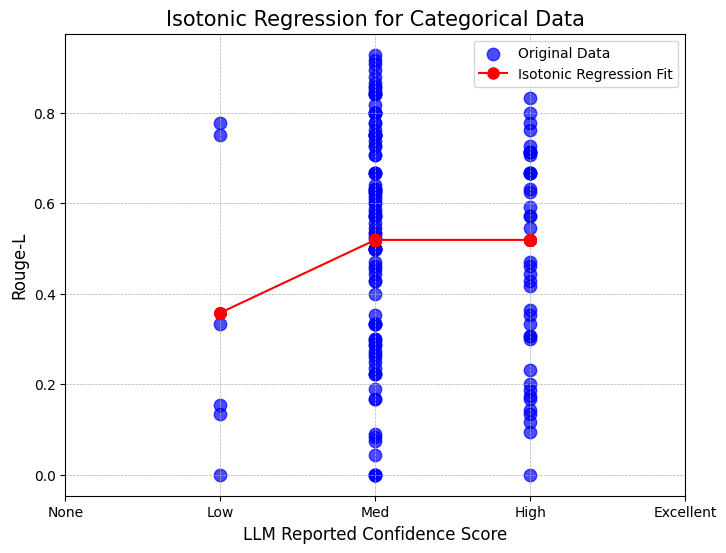

In [92]:
plt.figure(figsize=(8, 6))

# Plot the original data points
plt.scatter(trained_results['LLM Reported Confidence Score'], trained_results['rouge_l'], label='Original Data', color='blue', alpha=0.7, s=80)

# Plot the isotonic regression line
plt.plot(trained_results['LLM Reported Confidence Score'], trained_results['predicted_rouge_l'], 'r-o', label='Isotonic Regression Fit', markersize=8)

plt.title('Isotonic Regression for Categorical Data', fontsize=15)
plt.xlabel('LLM Reported Confidence Score', fontsize=12)
plt.ylabel('Rouge-L', fontsize=12)

# Use the original category labels for the x-axis ticks
plt.xticks(
    ticks=list(category_order.values()),
    labels=list(category_order.keys())
)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()